In [1]:
import pandas as pd
import numpy as np
import fastf1 

# Introduction 
In this notebook we will go over the telemetry data in order to explore different aggregation metrics for clustering of driving styles. For the time being we will only focus on the telemetry from Max Verstappen in the latest race (as of writing), the Japanese Grand Prix 2025. 

Telemetry data can be obtained on a per lap basis, therefore the process will be aas follows: 
- Select the event and session of interest 
- Load the session selected 
- Select the `.laps` for the session
- Pick the driver of interest by calling `.pick_drivers()`. At this point we have an object containing all of the laps data for the driver selected.
- Select each lap in the series of laps and extract car and positional data (`.telemetry` object may contain interpolated results and is not optimal for statistical applications)
- Create a table containing all of the car datapoints for all laps adding a to indicate the lap. 

In [2]:
fastf1.Cache.enable_cache('F:\Coding\ThesisProject\exploration\cache')
japan25 = fastf1.get_session(2025, 'Chinese Grand Prix', 'R')
japan25.load(telemetry=True)

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Pars

In [3]:
max_laps = japan25.laps.pick_drivers('VER')
max_laps.info()

<class 'fastf1.core.Laps'>
Index: 56 entries, 168 to 223
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                56 non-null     timedelta64[ns]
 1   Driver              56 non-null     object         
 2   DriverNumber        56 non-null     object         
 3   LapTime             55 non-null     timedelta64[ns]
 4   LapNumber           56 non-null     float64        
 5   Stint               56 non-null     float64        
 6   PitOutTime          1 non-null      timedelta64[ns]
 7   PitInTime           1 non-null      timedelta64[ns]
 8   Sector1Time         55 non-null     timedelta64[ns]
 9   Sector2Time         56 non-null     timedelta64[ns]
 10  Sector3Time         56 non-null     timedelta64[ns]
 11  Sector1SessionTime  55 non-null     timedelta64[ns]
 12  Sector2SessionTime  56 non-null     timedelta64[ns]
 13  Sector3SessionTime  56 non-null     timedelta64[ns

In [4]:
maxl1car = max_laps.pick_laps(1).get_car_data()
maxl1car.info()

<class 'fastf1.core.Telemetry'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Date         380 non-null    datetime64[ns] 
 1   RPM          380 non-null    int64          
 2   Speed        380 non-null    int64          
 3   nGear        380 non-null    int64          
 4   Throttle     380 non-null    int64          
 5   Brake        380 non-null    bool           
 6   DRS          380 non-null    int64          
 7   Source       380 non-null    object         
 8   Time         380 non-null    timedelta64[ns]
 9   SessionTime  380 non-null    timedelta64[ns]
dtypes: bool(1), datetime64[ns](1), int64(5), object(1), timedelta64[ns](2)
memory usage: 27.2+ KB


In [5]:
maxl1pos = max_laps.pick_laps(1).get_pos_data()
maxl1pos.info()

<class 'fastf1.core.Telemetry'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Date         388 non-null    datetime64[ns] 
 1   Status       388 non-null    object         
 2   X            388 non-null    int64          
 3   Y            388 non-null    int64          
 4   Z            388 non-null    int64          
 5   Source       388 non-null    object         
 6   Time         388 non-null    timedelta64[ns]
 7   SessionTime  388 non-null    timedelta64[ns]
dtypes: datetime64[ns](1), int64(3), object(2), timedelta64[ns](2)
memory usage: 24.4+ KB


In [6]:
def get_all_car_data_old(laps):
    race_car_data = pd.DataFrame()
    for index, lap in laps.iterrows():
        car_data = lap.get_car_data()
        car_data['LapNumber'] = lap.LapNumber
        race_car_data = pd.concat([race_car_data, car_data])
    return race_car_data

max_car = get_all_car_data_old(max_laps)


## Defining car data fetching function
In order to facilitate repeated fetching of driver telemetry I created a function that given a Session object and a driver Abbrevation returns a DataFrame of all car_data points. Additionally it adds a reference column for the lap and 2 boolean variables to indicate In/Out Laps.

In [7]:
def get_all_car_data(session: fastf1.core.Session, driver: str) -> pd.DataFrame:
    driver_laps = session.laps.pick_drivers(driver).copy()
    driver_laps.loc[:, 'InPit'] = driver_laps['PitOutTime'].notna()
    driver_laps.loc[:, 'OutPit'] = driver_laps['PitInTime'].notna()
    race_car_data = pd.DataFrame()
    for _, lap in driver_laps.iterrows():
        car_data = lap.get_car_data()
        car_data['LapNumber'] = lap.LapNumber
        car_data['LapNumber'] = car_data['LapNumber'].astype(int)
        car_data['OutPit'] = car_data['LapNumber'].isin(driver_laps[driver_laps['OutPit'] == True]['LapNumber'])
        car_data['InPit'] = car_data['LapNumber'].isin(driver_laps[driver_laps['InPit'] == True]['LapNumber'])
        car_data['Driver'] = driver
        car_data['Session'] = session.name
        car_data['TyreCompound'] = lap.Compound
        car_data['TyreLife'] = lap.TyreLife
        car_data['Acceleration'] = np.gradient(car_data.Speed)
        race_car_data = pd.concat([race_car_data, car_data])
    return race_car_data

In [8]:
max_japan = get_all_car_data(japan25, 'VER')
max_japan.info()

<class 'fastf1.core.Telemetry'>
Index: 20470 entries, 0 to 361
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Date          20470 non-null  datetime64[ns] 
 1   RPM           20470 non-null  int64          
 2   Speed         20470 non-null  int64          
 3   nGear         20470 non-null  int64          
 4   Throttle      20470 non-null  int64          
 5   Brake         20470 non-null  bool           
 6   DRS           20470 non-null  int64          
 7   Source        20470 non-null  object         
 8   Time          20470 non-null  timedelta64[ns]
 9   SessionTime   20470 non-null  timedelta64[ns]
 10  LapNumber     20470 non-null  int32          
 11  OutPit        20470 non-null  bool           
 12  InPit         20470 non-null  bool           
 13  Driver        20470 non-null  object         
 14  Session       20470 non-null  object         
 15  TyreCompound  20470 non-null  ob

# Plotting telemetry data 
In order to start exploring the structure of telemetry data I created a function that takes driver_data as input and returns a plot of the telemetry channel picked over the course of the race, expluding the first lap, the In lap and the Out lap. 

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_telemetry_channel_by_lap(driver_data: pd.DataFrame,
                             exclude_laps: set[int] | None = None,
                             channel: str = 'Speed',
                             title: str = "Driver Speed per Lap",
                             label_every_n: int = 5,
                             include_pits: bool = False,
                             exclude_first_lap: bool = True):
    """
    Plots the speed of a driver lap by lap, automatically excluding lap 1
    and laps flagged as InPit or OutPit, plus any laps specified in exclude_laps.

    Args:
        driver_data: DataFrame containing lap data with columns like
                     'LapNumber', 'Time' (timedelta), 'Speed', and potentially
                     boolean flags 'InPit' and 'OutPit'.
        exclude_laps: A set of additional lap numbers (int) to exclude from the plot.
                      Defaults to None (no *additional* laps excluded).
        channel: The telemetry channel to plot. Options are 'Speed', 'Throttle', 'Brake', 'RPM'.
        title: The title for the plot.
        label_every_n: Add a label to the legend for every n-th lap plotted.
                       Set to 0 or negative to disable lap labels in legend.
        include_pits: Whether to include pit laps in the plot.
    """
    # --- Input Data Checks ---
    required_cols = ['LapNumber', 'Time', 'Speed', 'Throttle', 'Brake', 'RPM']
    missing_req = [col for col in required_cols if col not in driver_data.columns]
    if missing_req:
        print(f"Error: Input DataFrame is missing required columns: {missing_req}")
        return

    # Make a copy to avoid SettingWithCopyWarning on the input DataFrame
    driver_data = driver_data.copy()

    # --- Data Preparation ---
    # Ensure 'Time' is timedelta
    if not pd.api.types.is_timedelta64_dtype(driver_data['Time']):
        try:
            driver_data['Time'] = pd.to_timedelta(driver_data['Time'])
        except Exception as e:
            print(f"Error converting 'Time' column to timedelta: {e}. Please ensure it's in a convertible format.")
            return

    # Ensure 'LapNumber' is integer, handling potential NaNs first
    if driver_data['LapNumber'].isnull().any():
        print("Warning: DataFrame contains NaN values in 'LapNumber'. These rows will be ignored.")
        driver_data = driver_data.dropna(subset=['LapNumber'])
    try:
        # Convert after ensuring no NaNs
        driver_data['LapNumber'] = driver_data['LapNumber'].astype(int)
    except Exception as e:
        print(f"Error converting 'LapNumber' column to int: {e}")
        return

    # --- Determine Laps to Exclude ---
    laps_to_exclude_final = set(exclude_laps) if exclude_laps is not None else set()

    # 1. Always exclude Lap 1
    if exclude_first_lap:
        laps_to_exclude_final.add(1)

    # 2. Exclude laps based on InPit flag, if the column exists
    if not include_pits:
        if 'InPit' in driver_data.columns:
            if driver_data['InPit'].isnull().any():
                print("Warning: 'InPit' column contains NaN values. Assuming NaN means False (not an InPit lap).")
                driver_data['InPit'] = driver_data['InPit'].fillna(False) # Handle NaNs in boolean flag
            if pd.api.types.is_bool_dtype(driver_data['InPit']):
                in_pit_laps = set(driver_data.loc[driver_data['InPit'] == True, 'LapNumber'].unique())
                laps_to_exclude_final.update(in_pit_laps)
            else:
                print("Warning: 'InPit' column is not boolean. Cannot use it for pit lap exclusion.")

        # 3. Exclude laps based on OutPit flag, if the column exists
        if 'OutPit' in driver_data.columns:
            if driver_data['OutPit'].isnull().any():
                print("Warning: 'OutPit' column contains NaN values. Assuming NaN means False (not an OutPit lap).")
                driver_data['OutPit'] = driver_data['OutPit'].fillna(False) # Handle NaNs in boolean flag
            if pd.api.types.is_bool_dtype(driver_data['OutPit']):
                out_pit_laps = set(driver_data.loc[driver_data['OutPit'] == True, 'LapNumber'].unique())
                laps_to_exclude_final.update(out_pit_laps)
            else:
                print("Warning: 'OutPit' column is not boolean. Cannot use it for pit lap exclusion.")

    # --- Filter Laps to Plot ---
    all_laps_in_data = sorted(driver_data['LapNumber'].unique()) # Already filtered NaNs and converted to int
    laps_to_plot = [lap for lap in all_laps_in_data if lap not in laps_to_exclude_final]

    if not laps_to_plot:
        excluded_laps_list = sorted(list(laps_to_exclude_final))
        print(f"No laps remaining to plot after automatically excluding Lap 1, Pit Laps, and manually specified laps.")
        print(f"Excluded Lap Numbers: {excluded_laps_list}")
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.set_title(title + " (No Laps to Plot)")
        ax.text(0.5, 0.5, "No valid laps found to plot.", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        plt.tight_layout()
        plt.show()
        return

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(15, 8))
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(laps_to_plot), vmax=max(laps_to_plot))

    plotted_lap_count = 0
    for lap in laps_to_plot:
        # Select data for the current lap *within* the loop
        lap_data = driver_data[driver_data['LapNumber'] == lap].sort_values('Time') # Ensure time is sorted for plotting
        if not lap_data.empty:
            time_seconds = lap_data['Time'].dt.total_seconds()
            color = cmap(norm(lap))

            # Add label conditionally based on label_every_n and the count of *plotted* laps
            label = f'Lap {lap}' if label_every_n > 0 and plotted_lap_count % label_every_n == 0 else ""
            ax.plot(time_seconds, lap_data[channel], color=color, alpha=0.7, label=label)
            plotted_lap_count += 1 # Increment counter only if lap data was found and plotted

    # --- Plot Configuration ---
    ax.set_xlabel("Time within Lap (s)")
    ax.set_ylabel(f"{channel}")
    # Update title to reflect the automatic exclusions
    ax.set_title(driver_data['Driver'].iloc[0] + " - " + channel + " per Lap" + " (Excluding Lap 1 & Pit Laps)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Lap Number')

    # Add legend only if labels were generated
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend()

    plt.tight_layout()
    plt.show()

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_183128\2852861094.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


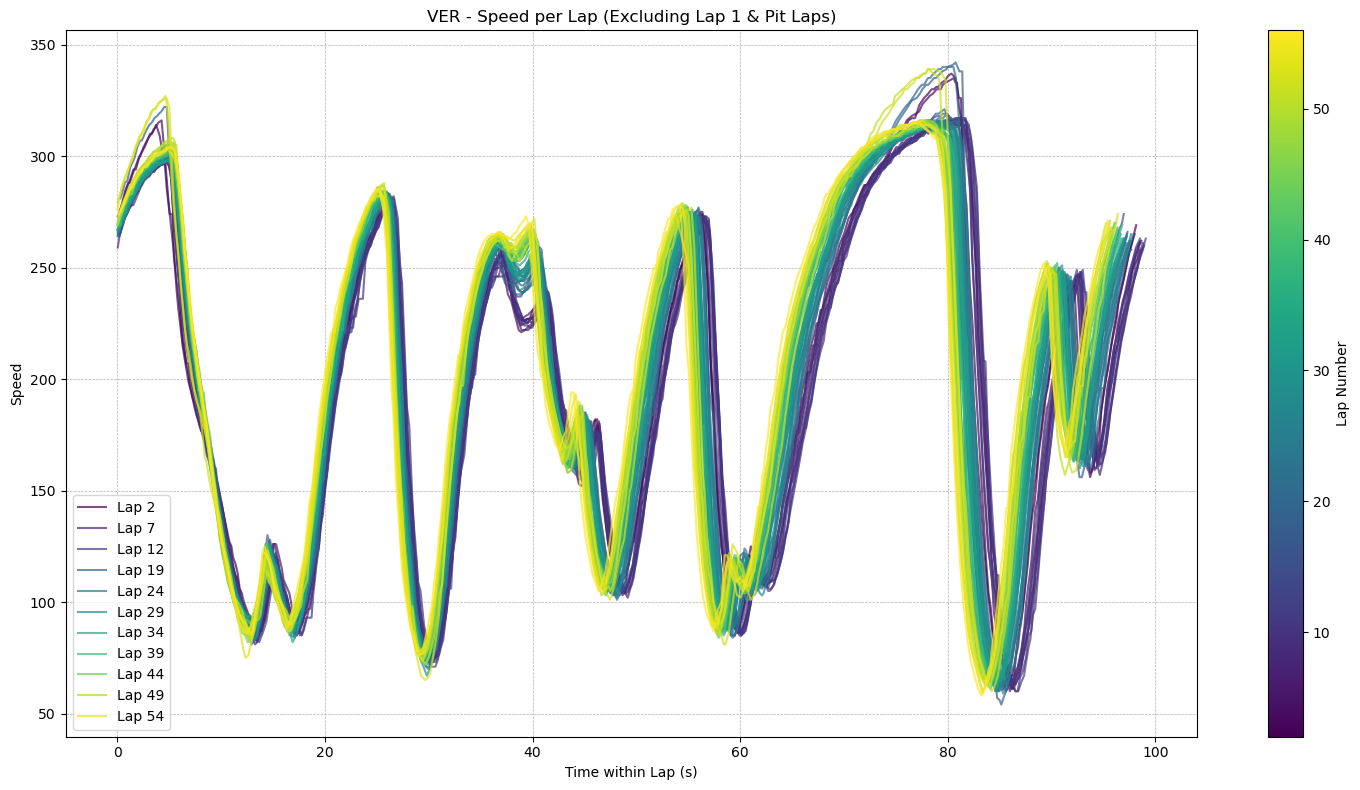

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_183128\2852861094.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


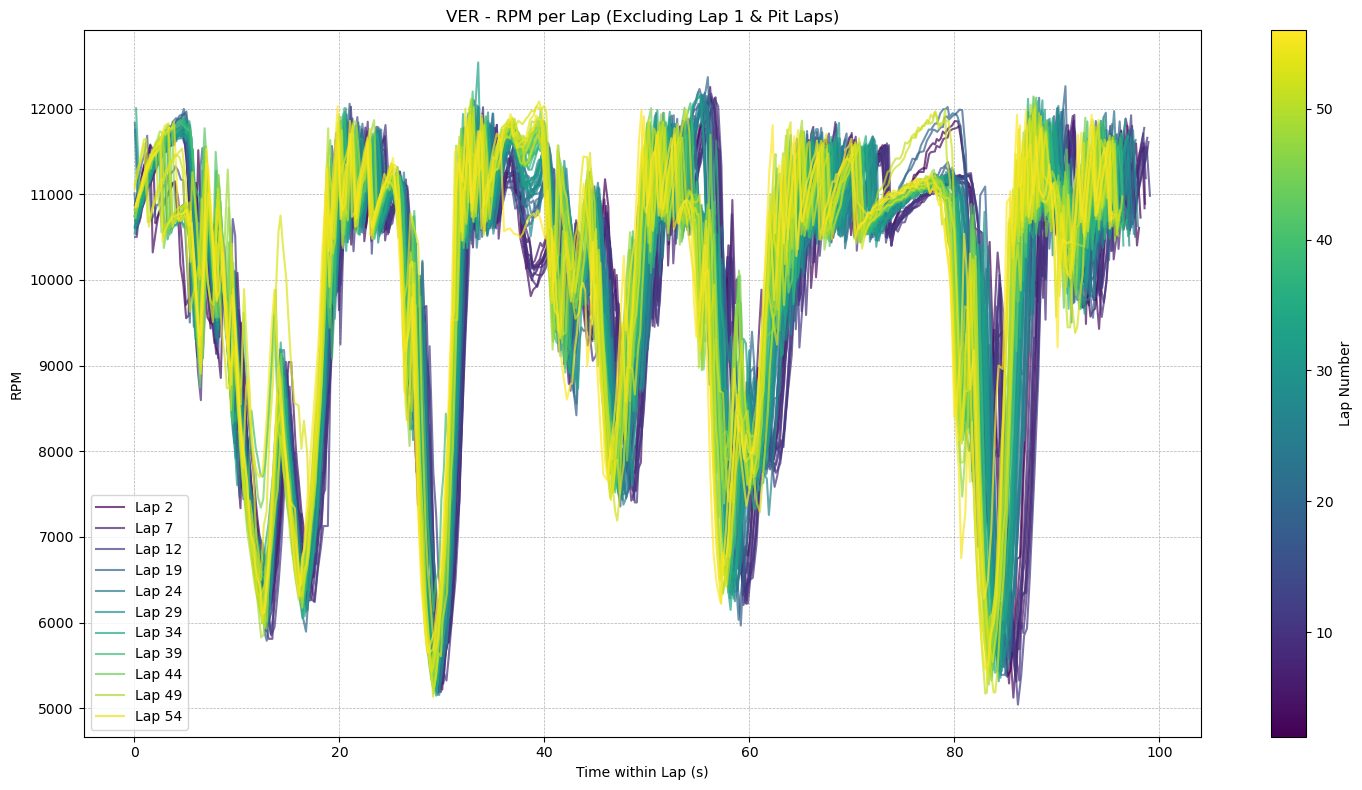

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_183128\2852861094.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


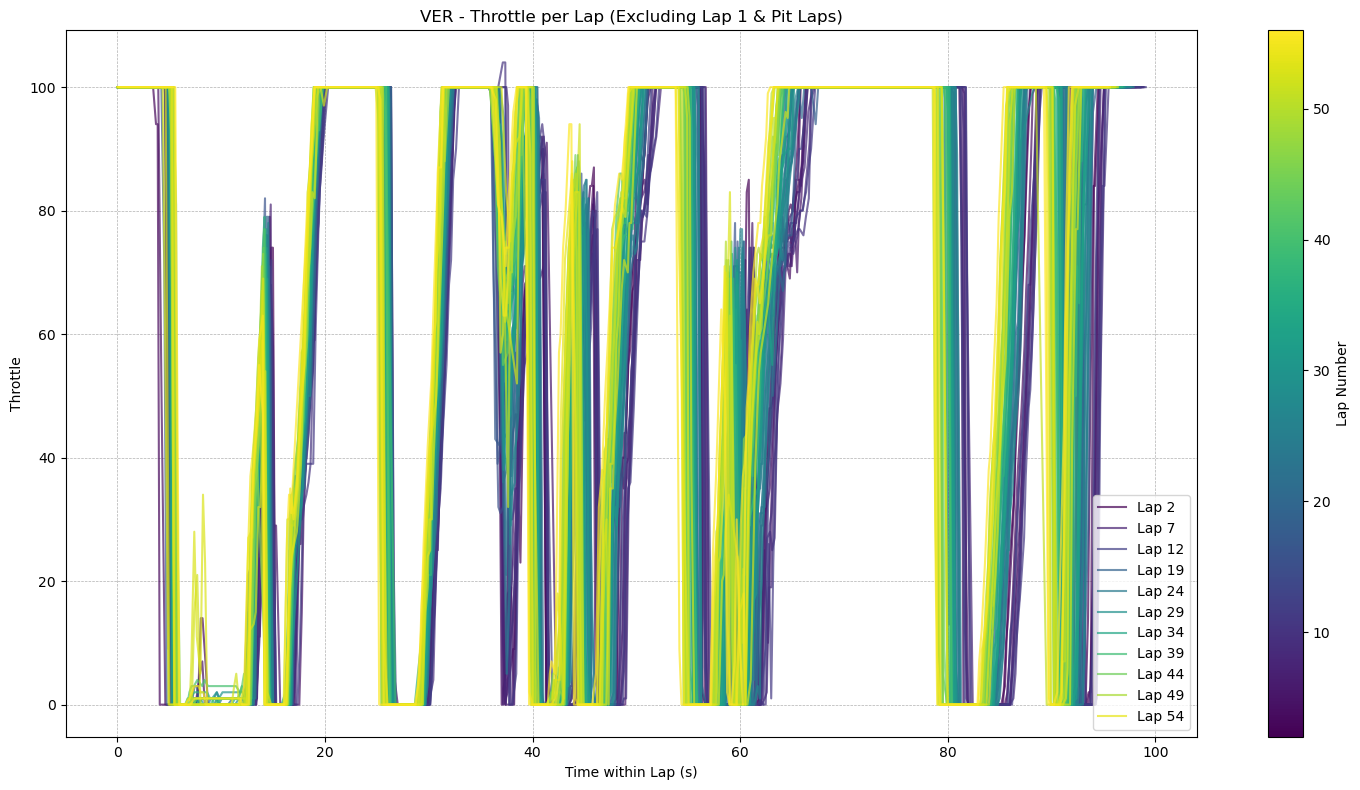

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_183128\2852861094.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


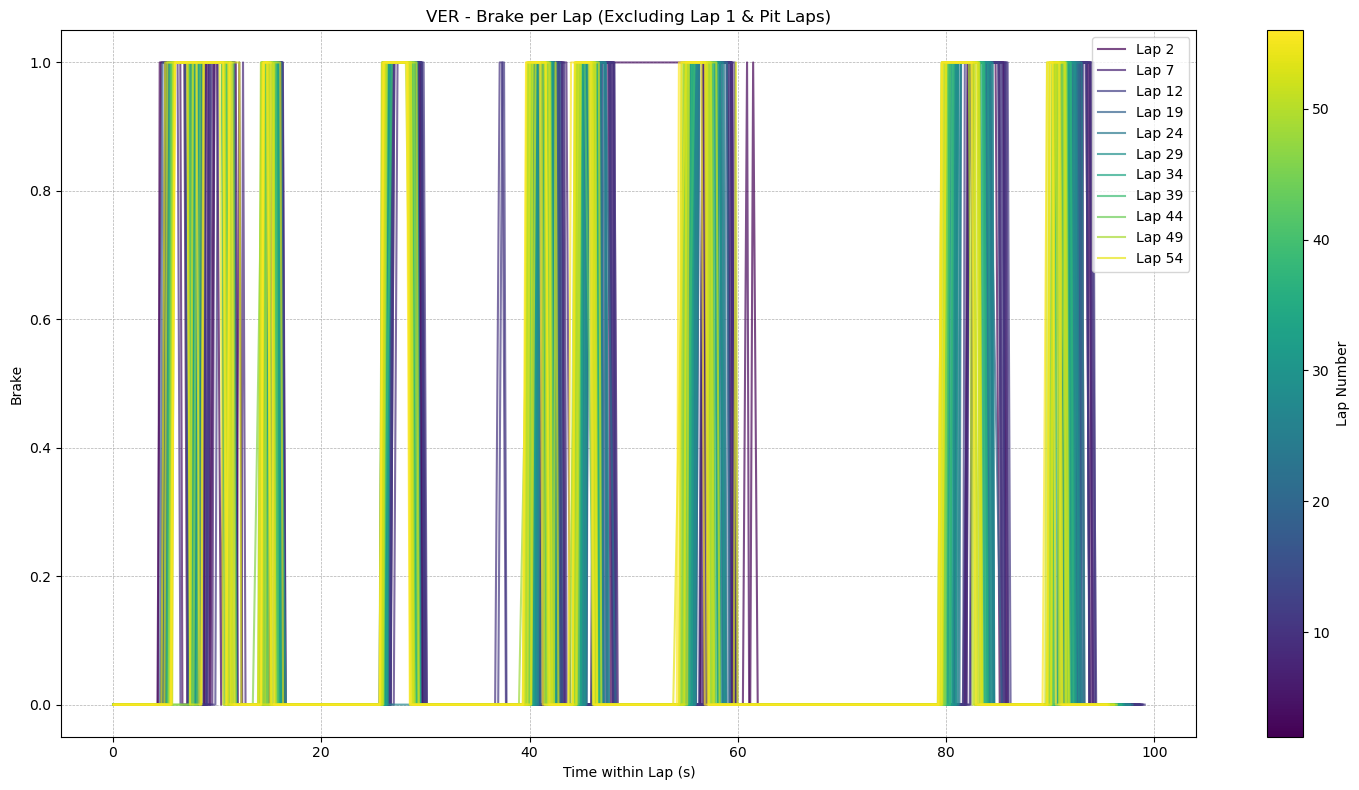

In [10]:
plot_telemetry_channel_by_lap(max_japan)
plot_telemetry_channel_by_lap(max_japan, channel='RPM')

plot_telemetry_channel_by_lap(max_japan, channel='Throttle')
plot_telemetry_channel_by_lap(max_japan, channel='Brake')